Advanced Pandas — apply/map/lambda & Feature Engineering on Airbnb


Objectives
- Practice apply/map/lambda and vectorized transforms vs. row-wise apply.
- Build reusable custom functions for cleaning and feature engineering.
- Create new features for listings

Dataset: InsideAirbnb — Albany, NY (listings, calendar, reviews) snapshot


In [1]:
# Environment check & imports
import sys, os, gzip, shutil, urllib.request
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
print("Python", sys.version.split()[0], "pandas", pd.__version__, "numpy", np.__version__)

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)


Python 3.12.12 pandas 2.2.2 numpy 2.0.2


In [3]:
base = "https://data.insideairbnb.com/united-states/ny/albany/2025-10-05"
files = {
    "listings": f"{base}/data/listings.csv.gz",
    "calendar": f"{base}/data/calendar.csv.gz",
    "reviews":   f"{base}/data/reviews.csv.gz"
}

def download_and_decompress(name, url, out_dir=DATA_DIR):
    out_gz = out_dir / f"{name}.csv.gz"
    out_csv = out_dir / f"{name}.csv"
    if out_csv.exists():
        print(f"{name} already present:", out_csv)
        return out_csv
    print("Downloading", url)
    urllib.request.urlretrieve(url, out_gz)
    # decompress
    with gzip.open(out_gz, "rb") as f_in, open(out_csv, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    print("Saved", out_csv)
    return out_csv

listings_path = download_and_decompress("listings", files["listings"])
calendar_path = download_and_decompress("calendar", files["calendar"])
reviews_path = download_and_decompress("reviews", files["reviews"])


listings already present: data/listings.csv
calendar already present: data/calendar.csv
reviews already present: data/reviews.csv


In [4]:
# Load
listings = pd.read_csv(listings_path)
calendar = pd.read_csv(calendar_path)
reviews = pd.read_csv(reviews_path)

print("Listings:", listings.shape)
print("Calendar:", calendar.shape)
print("Reviews:", reviews.shape)

# Quick peek
display(listings.head(2).T)
display(calendar.head(2).T)
display(reviews.head(2).T)


Listings: (461, 79)
Calendar: (168265, 7)
Reviews: (27864, 6)


,0,1
id,2992450,3820211
listing_url,https://www.airbnb.com/rooms/2992450,https://www.airbnb.com/rooms/3820211
scrape_id,20251005230129,20251005230129
last_scraped,2025-10-05,2025-10-06
source,city scrape,city scrape
...,...,...
calculated_host_listings_count,1,5
calculated_host_listings_count_entire_homes,1,5
calculated_host_listings_count_private_rooms,0,0
calculated_host_listings_count_shared_rooms,0,0


,0,1
listing_id,2992450,2992450
date,2025-10-05,2025-10-06
available,f,f
price,NaN,NaN
adjusted_price,NaN,NaN
minimum_nights,28,28
maximum_nights,1125,1125


,0,1
listing_id,2992450,2992450
id,15066586,21810844
date,2014-07-01,2014-10-24
reviewer_id,16827297,22648856
reviewer_name,Kristen,Christopher
comments,Large apartment; nice kitchen and bathroom. Ke...,"This may be a little late, but just to say Ken..."


In [5]:
listings[['availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'availability_eoy',]].head()

,availability_30,availability_365,availability_60,availability_90,availability_eoy
0,0,188,0,0,0
1,30,354,49,79,76
2,0,12,0,12,10
3,0,335,30,60,58
4,0,246,0,0,0


In [6]:
reviews.loc[1, 'comments']

'This may be a little late, but just to say Kenneth was quick to respond to our request. He left some supplies in the refrigerator and kindly showed us round downtown Albany. We were without a car and he arranged for his cousin Kristina to take us to  supermarket.\r<br/>The apartment is large, clean with many original features. It is situated in an historical area that is fairly central, although like the rest of Albany you have to climb a steep hill to get to it if you are on foot. \r<br/>'

In [7]:
# how would I grab this value 5485362 from my dataframe using iloc
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2992450,15066586,2014-07-01,16827297,Kristen,Large apartment; nice kitchen and bathroom. Ke...
1,2992450,21810844,2014-10-24,22648856,Christopher,"This may be a little late, but just to say Ken..."
2,2992450,27434334,2015-03-04,45406,Altay,The apartment was very clean and convenient to...
3,2992450,28524578,2015-03-25,5485362,John,Kenneth was ready when I got there and arrange...
4,2992450,35913434,2015-06-23,15772025,Jennifer,We were pleased to see how 2nd Street and the ...


In [14]:
reviews.iloc[3, 3]

np.int64(5485362)

In [13]:
reviews.iloc[3][3]

/tmp/ipython-input-1322664045.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reviews.iloc[3][3]


np.int64(5485362)

In [10]:
reviews.loc[3, 'reviewer_id']

np.int64(5485362)

In [9]:
reviews.loc[3]['reviewer_id']

np.int64(5485362)

## Quick cleaning recap (coerce types, normalize strings)
We'll:
- Create numeric price fields
- Normalize key text columns (neighbourhood, room type, host_name)
- Parse date fields for features (host_since, first_review, last_review)


In [15]:
# listings
[x for x in listings.columns if 'price' in x.lower()]

['price']

In [16]:
# clean price column from the listings table
listings['price_clean'] = pd.to_numeric(listings['price'].str.split("$",
                                          expand=True)[1].str.replace(',', ""))

In [17]:
listings['price'].describe()

,price
count,425
unique,166
top,$92.00
freq,10


In [18]:
listings['price_clean'].describe()

,price_clean
count,425.000000
mean,119.880000
std,119.955032
min,24.000000
25%,68.000000
50%,94.000000
75%,126.000000
max,1314.000000


In [19]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_clean
0,2992450,https://www.airbnb.com/rooms/2992450,20251005230129,2025-10-05,city scrape,Luxury 2 bedroom apartment,The apartment is located in a quiet neighborho...,NaN,https://a0.muscache.com/pictures/44627226/0e72...,4621559,...,3.22,3.67,NaN,f,1,1,0,0,0.07,93.0
1,3820211,https://www.airbnb.com/rooms/3820211,20251005230129,2025-10-06,city scrape,Funky Urban Gem: Prime Central Location - Park...,Step into the charming and comfy 1BR/1BA apart...,Overview<br /><br />The lovely apartment is lo...,https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.81,4.77,NaN,f,5,5,0,0,2.29,91.0
2,5651579,https://www.airbnb.com/rooms/5651579,20251005230129,2025-10-06,city scrape,Large studio apt by Capital Center & ESP@,"Spacious studio with hardwood floors, fully eq...",The neighborhood is very eclectic. We have a v...,https://a0.muscache.com/pictures/b3fc42f3-6e5e...,29288920,...,4.76,4.64,NaN,f,2,1,1,0,2.94,64.0
3,6623339,https://www.airbnb.com/rooms/6623339,20251005230129,2025-10-05,city scrape,Cozy City Stay · Free Parking + Walkable Location,Step into the charming and comfy 1BR/1BA apart...,Overview<br /><br />The lovely apartment is lo...,https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.80,4.72,NaN,f,5,5,0,0,2.64,95.0
4,9005989,https://www.airbnb.com/rooms/9005989,20251005230129,2025-10-05,city scrape,"Studio in The heart of Center SQ, in Albany NY",(21 years of age or older ONLY) NON- SMOKING.....,"There are many shops, restaurants, bars, museu...",https://a0.muscache.com/pictures/d242a77e-437c...,17766924,...,4.87,4.77,NaN,f,1,1,0,0,5.58,89.0


<Axes: xlabel='price_clean', ylabel='Count'>

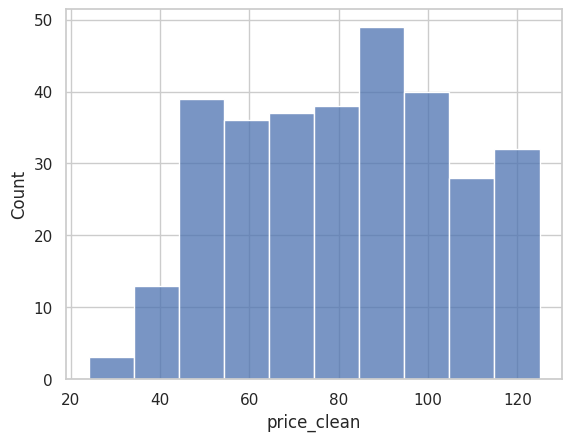

In [21]:
import seaborn as sns
sns.histplot(listings[listings['price_clean'] < 126]['price_clean'])

In [22]:
listings[[x for x in listings.columns if 'neighbourhood' in x.lower()]].isnull().sum() / listings.shape[0]

,0
host_neighbourhood,0.175705
neighbourhood,0.609544
neighbourhood_cleansed,0.000000
neighbourhood_group_cleansed,1.000000


In [23]:
listings[listings['neighbourhood_cleansed'] == 'third ward'].head(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_clean


In [24]:
# neighbourhood

listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].str.lower()

In [25]:
listings.groupby('neighbourhood_cleansed')['price_clean'].median().sort_values(ascending=False)

,price_clean
neighbourhood_cleansed,
eighth ward,203.5
fifteenth ward,177.0
twelfth ward,135.0
first ward,133.0
second ward,109.0
fourth ward,104.0
sixth ward,96.0
thirteenth ward,92.5
third ward,90.0


In [26]:
def lowercase_obj_column(df, col):
  my_col = df[col].str.lower()
  return my_col

In [27]:
# (room type, host_name)
listings['room_type_clean'] = lowercase_obj_column(listings, 'room_type')
listings['room_type_clean'].unique()

array(['entire home/apt', 'private room', 'hotel room'], dtype=object)

In [28]:
listings.groupby('room_type_clean')['price_clean'].median().sort_values(ascending=False)

,price_clean
room_type_clean,
entire home/apt,105.0
private room,56.5
hotel room,NaN


In [31]:
listings.groupby(['room_type_clean',
                  'neighbourhood_cleansed'])['price_clean'].median().unstack().T#.T#.sort_values('entire home/apt',
                                                                                             #ascending=False)

room_type_clean,entire home/apt,hotel room,private room
neighbourhood_cleansed,,,
eighth ward,208.0,NaN,59.0
eleventh ward,60.0,NaN,53.0
fifteenth ward,187.0,NaN,47.0
fifth ward,53.5,NaN,93.0
first ward,133.0,NaN,NaN
fourteenth ward,152.0,NaN,56.0
fourth ward,104.0,NaN,104.0
ninth ward,97.0,NaN,60.0
second ward,110.0,NaN,59.5


In [32]:
listings['host_name_clean'] = lowercase_obj_column(listings, 'host_name')
sorted(listings['host_name_clean'].unique())[:5]

['abdelrahman', 'abdullah', 'abel', 'adriana', 'ahmad']

## apply, map, lambda — quick guide
- vectorized string methods and arithmetic are fastest (use Pandas built-ins when possible).  
- `.map()` is good for mapping a Series via dict or function to new values.  
- `.apply()` (row or column) runs Python code per element and is slower — use for complex row-wise logic not expressible in vectorized form.  
We'll show examples comparing approaches.


In [101]:
%%timeit
listings['price_clean'] / 2

59.3 µs ± 6.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
%%timeit
listings['price_clean'].apply(lambda x: x / 2)

181 µs ± 8.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [104]:
%%timeit
my_vals = []
for x in listings['price_clean']:
  my_vals.append(x / 2)

88.1 µs ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [33]:
# map example
df = pd.DataFrame({
    "product": ["A", "B", "C"],
    "price": [10.5, 20.75, 30.99]
})

# Dictionary mapping
df["product_dict_mapping"] = df["product"].map({"A": "Alpha", "B": "Beta"})

# Define a custom function
def categorize_price(p):
    if p < 10:
        return "Low"
    elif p < 25:
        return "Medium"
    else:
        return "High"

# Apply custom function with map
df["price_category"] = df["price"].map(categorize_price)
df.head()


,product,price,product_dict_mapping,price_category
0,A,10.50,Alpha,Medium
1,B,20.75,Beta,Medium
2,C,30.99,NaN,High


In [35]:
# Create feature: price_per_person = price_clean / accommodates (if available)
listings["accommodates"] = pd.to_numeric(listings["accommodates"], errors='coerce')
listings["price_per_person"] = listings["price_clean"] / listings["accommodates"]

In [36]:
# Example fallback using apply
def ppp_row(r):
    try:
        return float(r["price_clean"]) / int(r["accommodates"])
    except Exception:
        return np.nan
listings["price_per_person_apply"] = listings[["price_clean","accommodates"]].apply(lambda r: ppp_row(r), axis=1)
display(listings[["id","price_clean","accommodates","price_per_person","price_per_person_apply"]].head())


,id,price_clean,accommodates,price_per_person,price_per_person_apply
0,2992450,93.0,4,23.250000,23.250000
1,3820211,91.0,3,30.333333,30.333333
2,5651579,64.0,2,32.000000,32.000000
3,6623339,95.0,2,47.500000,47.500000
4,9005989,89.0,4,22.250000,22.250000


In [37]:
listings.shape

(461, 84)

In [111]:
%%timeit
listings["accommodates"] = pd.to_numeric(listings["accommodates"], errors='coerce')
listings["price_per_person"] = listings["price_clean"] / listings["accommodates"]

452 µs ± 218 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [112]:
%%timeit
listings["price_per_person_apply"] = listings[["price_clean","accommodates"]].apply(lambda r: ppp_row(r), axis=1)

4.79 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
# host tenure
listings['host_since'] = pd.to_datetime(listings['host_since'])
# ref data
today = pd.Timestamp("2025-11-25")
listings['host_since_days'] = (today - listings['host_since']).dt.days
listings['host_since_years'] = (listings['host_since_days'] / 365).round(2)
listings[['host_since', 'host_since_days', 'host_since_years']].head()

,host_since,host_since_days,host_since_years
0,2013-01-07,4705,12.89
1,2014-08-07,4128,11.31
2,2015-03-13,3910,10.71
3,2014-08-07,4128,11.31
4,2014-07-07,4159,11.39


In [45]:
listings['host_since_years'].describe().round(2)

,host_since_years
count,461.00
mean,7.04
std,3.30
min,0.32
25%,4.67
50%,6.92
75%,10.05
max,14.50


In [39]:
listings['host_since'].describe()

,host_since
count,461
mean,2018-11-12 16:23:56.876355840
min,2011-05-31 00:00:00
25%,2015-11-08 00:00:00
50%,2018-12-28 00:00:00
75%,2021-03-27 00:00:00
max,2025-07-30 00:00:00


In [41]:
# convert host_response_rate to be numerical
# bin host response rate into
# low, medium, and high

listings['host_response_rate_clean'] = pd.to_numeric(
    listings['host_response_rate'].str.replace('%', ''))

bins = [0, 50, 80, 100]
labels = ['low', 'medium', 'high']

listings['response_bucket'] = pd.cut(listings['host_response_rate_clean'],
                                     bins=bins, labels=labels)
listings[['host_response_rate_clean', 'response_bucket']].head(10)

,host_response_rate_clean,response_bucket
0,NaN,NaN
1,100.0,high
2,100.0,high
3,100.0,high
4,NaN,NaN
5,100.0,high
6,100.0,high
7,100.0,high
8,100.0,high
9,100.0,high


In [46]:
listings['host_response_rate_clean'].value_counts(normalize=True)

,proportion
host_response_rate_clean,
100.0,0.797701
97.0,0.048276
95.0,0.039080
80.0,0.036782
90.0,0.018391
98.0,0.016092
99.0,0.013793
0.0,0.009195
83.0,0.006897


In [48]:
calendar['available'].unique()

array(['f', 't'], dtype=object)

In [50]:
calendar['available_flag'] = calendar['available'].map({'t': True, 'f': False})

In [51]:
calendar_agg = calendar.groupby('listing_id').agg(pct_available=('available_flag', 'mean'),
                                   days_available=('available_flag', 'sum'))

In [52]:
calendar_agg.reset_index(inplace=True)

In [54]:
calendar_agg.head(10)

,listing_id,pct_available,days_available
0,2992450,0.515068,188
1,3820211,0.969863,354
2,5651579,0.032877,12
3,6623339,0.917808,335
4,9005989,0.673973,246
5,9501054,0.663014,242
6,10768745,0.430137,157
7,11253948,0.947945,346
8,11639446,0.997260,364
9,12799126,0.843836,308


In [55]:
# join with listings dataframe
listings_join = listings.merge(calendar_agg, left_on='id', right_on='listing_id',
                               how='left')

In [56]:
listings_join[['id', 'price_clean', 'accommodates', 'pct_available', 'days_available']].head()

,id,price_clean,accommodates,pct_available,days_available
0,2992450,93.0,4,0.515068,188
1,3820211,91.0,3,0.969863,354
2,5651579,64.0,2,0.032877,12
3,6623339,95.0,2,0.917808,335
4,9005989,89.0,4,0.673973,246


In [64]:
reviews['num_words'] = reviews['comments'].str.split().str.len()

In [57]:
reviews['review_len'] = reviews['comments'].str.len()

In [58]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,review_len
0,2992450,15066586,2014-07-01,16827297,Kristen,Large apartment; nice kitchen and bathroom. Ke...,376.0
1,2992450,21810844,2014-10-24,22648856,Christopher,"This may be a little late, but just to say Ken...",492.0
2,2992450,27434334,2015-03-04,45406,Altay,The apartment was very clean and convenient to...,197.0
3,2992450,28524578,2015-03-25,5485362,John,Kenneth was ready when I got there and arrange...,1242.0
4,2992450,35913434,2015-06-23,15772025,Jennifer,We were pleased to see how 2nd Street and the ...,1288.0


In [65]:
reviews['date'] = pd.to_datetime(reviews['date'])

#reviews.groupby('id')['date'].max()

In [66]:
reviews.groupby('listing_id').agg(most_recent_review=('date', 'max'),
                                  average_review_len=('review_len', 'mean'),
                                  average_review_words=('num_words', 'mean'),
                                  review_count=('id', 'count'))

,most_recent_review,average_review_len,average_review_words,review_count
listing_id,,,,
2992450,2022-08-17,604.777778,114.333333,9
3820211,2025-08-04,247.096463,43.282958,311
5651579,2025-09-15,203.512064,36.152815,373
6623339,2025-06-30,244.542169,42.442771,332
9005989,2025-08-03,174.489567,30.646870,623
...,...,...,...,...
1498161268794053659,2025-09-29,151.250000,27.250000,4
1503537470526077849,2025-09-14,20.000000,4.000000,1
1509560756079358837,2025-09-26,28.000000,4.000000,1


In [73]:
# for each neighborhood
# grab median price per person
# the number of listings
neighborhood_agg = listings.groupby('neighbourhood_cleansed').agg(median_price_per_person=('price_per_person', 'median'),
                                               listing_count=('id', 'count')
                                               ).sort_values('median_price_per_person',
                                                ascending=False)
neighborhood_agg

,median_price_per_person,listing_count
neighbourhood_cleansed,,
sixth ward,43.500000,98
tenth ward,41.333333,47
eighth ward,38.966667,10
ninth ward,35.750000,35
third ward,35.000000,39
fourth ward,34.000000,17
seventh ward,34.000000,15
thirteenth ward,33.250000,43
second ward,31.500000,51


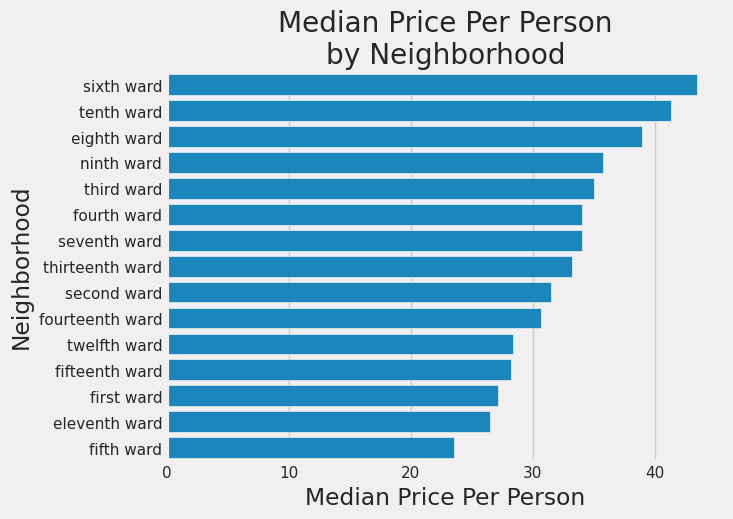

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

with plt.style.context('fivethirtyeight'):
  sns.barplot(data=neighborhood_agg, x='median_price_per_person',
              y=neighborhood_agg.index)
  plt.title('Median Price Per Person\nby Neighborhood')
  plt.xlabel('Median Price Per Person')
  plt.ylabel('Neighborhood')